#### dependencies

In [ ]:
!pip install EMD-signal
!pip install prophet
!pip install xlrd ==2.0.1
!pip install pmdarima

In [ ]:
# !pip freeze > requirements.txt
# !pip uninstall -r requirements.txt -y

#### imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error , mean_squared_error, mean_absolute_error

In [ ]:
from PyEMD import EMD
from PyEMD import CEEMDAN
from prophet import Prophet
from pmdarima import auto_arima

# **1. Solar-2018**


## 1.0 Read Data

In [ ]:
path = "/Datasets/Renewable_Energy_Consumption_Industrial_and_Transportation.xlsx"
df = pd.read_excel(path, header=10, parse_dates=["Month"], usecols=["Month", "Solar Energy Consumed by the Industrial Sector"])

In [ ]:
df.drop(0, inplace=True)
df= df[df.Month>= "2005-01-01"]
df = df[df.Month<"2018-01-01"]
df.columns=['ds', 'y']
df.index= range(len(df))
df.head()

,ds,y
0,2005-01-01,0.022
1,2005-02-01,0.024
2,2005-03-01,0.032
3,2005-04-01,0.036
4,2005-05-01,0.039


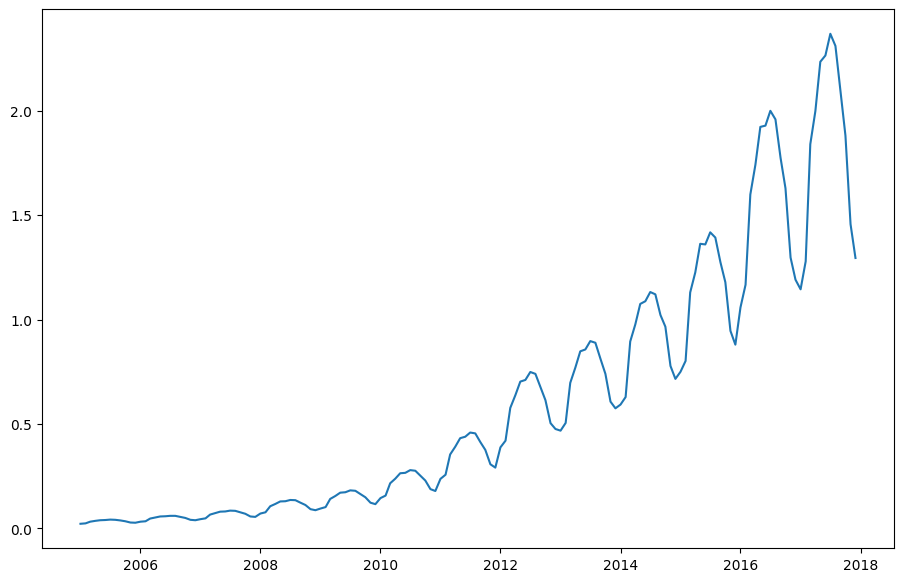

In [ ]:
plt.rcParams["figure.figsize"] = (11,7)
fig = plt.plot(df.ds, df.y)

In [ ]:
solar_test_size = 12
solar_train_set = df[:len(df)-solar_test_size]
solar_test_set = df[len(df)-solar_test_size:]

In [ ]:
ds = df.ds

## 1.1 prophet

In [ ]:
model = Prophet(seasonality_mode = "multiplicative")
model.fit(solar_train_set)
future = model.make_future_dataframe(len(solar_test_set), freq="MS" )
forecast = model.predict(future)

In [ ]:
solar_prophet_mape = mean_absolute_percentage_error(solar_test_set.y, forecast.yhat[-solar_test_size:])
solar_prophet_rmse=np.sqrt(mean_squared_error(solar_test_set.y, forecast.yhat[-solar_test_size:]))
solar_prophet_mae = mean_absolute_error(solar_test_set.y, forecast.yhat[-solar_test_size:])

print("MAPE : ", solar_prophet_mape)
print("RMSE : ", solar_prophet_rmse)
print("MAE   : ", solar_prophet_mae)


MAPE :  0.0322839957766223
RMSE :  0.0630745973488649
MAE   :  0.050004218199769


## 1.2 Prophet-EMD

### decomposition

In [ ]:
emd = EMD()
solar_imfs = emd.emd(np.array(list(solar_train_set.y.values)))
solar_imfs.shape

(3, 144)

###+Prophet

In [ ]:
forecast_temp=pd.DataFrame()
forecast_temp['ds'] = ds
forecast_temp['yhat']=0

for imf in solar_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = ds
  temp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="multiplicative")
  model.fit(temp)
  future = model.make_future_dataframe(solar_test_size, freq="MS")
  forecast = model.predict(future)
  forecast_temp["yhat"] += forecast['yhat']

## 1.3 Prophet-CEEMDAN

### Decomposition

In [ ]:
ceemd = CEEMDAN()
solar_c_imfs = ceemd.ceemdan(np.array(list(solar_train_set.y.values)))
solar_c_imfs.shape

(3, 144)

### + Prophet

In [ ]:
forecast_temp=pd.DataFrame()
forecast_temp['ds'] = ds
forecast_temp['yhat']=0

for imf in solar_c_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = ds
  temp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="multiplicative")
  model.fit(temp)
  future = model.make_future_dataframe(12, freq="MS")
  forecast = model.predict(future)
  forecast_temp["yhat"] += forecast['yhat']

## 1.4 Prophet-ICEEMDAN

### import imfs

In [ ]:
solar1_ic_imfs = pd.read_csv("/ICEEMDAN-IMFS/IMF_solar1.csv", header=None)
solar1_ic_imfs.head()

,0,1,2,3,4,5,6,7,8,9,...,134,135,136,137,138,139,140,141,142,143
0,-0.001637,-0.002074,0.001592,0.000949,0.000239,-0.001291,-0.000125,0.000187,0.000469,0.000823,...,0.052944,-0.039948,0.028190,-0.022239,0.023805,0.018389,-0.040919,0.049296,-0.054382,-0.054251
1,-0.007679,-0.005141,-0.000842,0.003623,0.007004,0.009045,0.009226,0.007096,0.002849,-0.002597,...,0.111794,0.314144,0.401742,0.445370,0.461176,0.427926,0.307488,0.095530,-0.105448,-0.184066
2,0.031316,0.031215,0.031250,0.031428,0.031758,0.032246,0.032899,0.033717,0.034682,0.035774,...,1.435263,1.465805,1.490069,1.506869,1.515019,1.513685,1.503431,1.485174,1.459831,1.428317


In [ ]:
solar1_ic_imfs.shape

(3, 144)

In [ ]:
solar1_ic_imfs=solar1_ic_imfs.to_numpy()

### + prophet

In [ ]:
solar1_forecast_temp_ice=pd.DataFrame()
solar1_forecast_temp_ice["ds"] = ds
solar1_forecast_temp_ice["yhat"] = 0

for imf in solar1_ic_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = ds
  temp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="multiplicative")
  model.fit(temp)
  future = model.make_future_dataframe(12, freq="MS")
  solar1_forecast = model.predict(future)
  solar1_forecast_temp_ice["yhat"] += solar1_forecast['yhat']

## 1.5 SARIMAX

In [ ]:
temp = solar_train_set.copy()
temp.index = solar_train_set.ds
temp.drop("ds", axis=1,inplace=True)

In [ ]:
model_arima = auto_arima(temp,seasonal=True, m=12, stationary=True)
forecast_arima = model_arima.predict(len(solar_test_set))

In [ ]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(2, 0, 2)x(2, 0, [], 12)   Log Likelihood                 324.743
Date:                             Fri, 18 Aug 2023   AIC                           -633.486
Time:                                     07:35:16   BIC                           -609.728
Sample:                                 01-01-2005   HQIC                          -623.832
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.003      0.359      0.720      -0.005       0.008
ar.L1          1.3902      0.166      8.386      0.000       1.065       1.715
ar.L2         -0.4172      0.163     -2.562      0.010      -0.736      -0.098
ma.L1         -0.0727      0.149     -0.488      0.626      -0.365       0.219
ma.L2          0.3755      0.078      4.807      0.000       0.222       0.529
ar.S.L12       1.3964      0.049     28.442      0.000       1.300       1.493
ar.S.L24      -0.4438      0.059     -7.470      0.000      -0.560      -0.327
sigma2         0.0005   2.38e-05     19.649      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1541.76
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):             118.08   Skew:                             1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# plots

### test set chart

In [ ]:
def plotting_test(df, df_p, df_ep, df_cp, df_icp, df_s, ylabel, xlabel, name, test_size):
  fig, ax = plt.subplots(layout="constrained", figsize=(12,7))
  plt.rcParams['font.family'] = 'serif'
  plt.rcParams['font.serif'] += ['Times New Roman']

  width = 3
  msize = 9

  ax.plot(df.ds[-test_size:], df.y[-test_size:], label = "Original",color ='black', marker = 'o', ms= msize-2, lw=width, mfc = 'white', zorder=10, alpha=0.9)
  ax.plot(df_p.ds[-test_size:], df_p.yhat[-test_size:], label = "Prophet", marker = 'X', ms = msize+1, lw=width, mfc='white')
  ax.plot(df_ep.ds[-test_size:], df_ep.yhat[-test_size:], label = "Prophet-EMD", marker = '^', markersize = msize, lw=width,  mfc = 'white')
  ax.plot(df_cp.ds[-test_size:], df_cp.yhat[-test_size:], label = "Prophet-CEEMDAN", marker = 'h', ms = msize+1, lw=width, mfc='white')
  ax.plot(df_icp.ds[-test_size:], df_icp.yhat[-test_size:], label = "Prophet-ICEEMDAN", marker = 'P', ms = msize, lw=width, mfc='white' , alpha=1)
  ax.plot(df_cp.ds[-test_size:], df_s,  label = "SARIMAX", marker='v', ms=msize+1, lw=width, mfc='white')

  plt.margins(0.05,0.5)
  ax.legend(fontsize = 15, loc='upper left')
  plt.grid(axis='y')
  plt.ylabel(ylabel, fontsize=17, labelpad=15, fontfamily= "serif", fontweight="bold")
  plt.xlabel(xlabel, fontsize=17, labelpad=10, fontfamily= "serif", fontweight="bold")
  ceil = ax.get_ylim()
  plt.ylim(ceil[0], ceil[1]+(0.05*ceil[1]))

  plt.xticks(df.ds[-test_size:], rotation = 30, fontweight="bold", fontsize = 13)
  plt.yticks(fontweight='bold', fontsize = 13)

  plt.savefig(name, dpi=1200)


#### reading data

In [ ]:
df1 = pd.read_excel("/Forecasts/solar-2018/solar1_Prophet.xlsx")
df1 = df1[['ds', 'yhat']]

In [ ]:
df2 = pd.read_excel("/Forecasts/solar-2018/solar1_prophet-EMD.xlsx")
df2 = df2[['ds', 'yhat']]

In [ ]:
df3 = pd.read_excel("/Forecasts/solar-2018/solar1_prophet-CEEMDAN.xlsx")
df3 = df3[['ds', 'yhat']]

In [ ]:
df4 =pd.read_excel("/Forecasts/solar-2018/solar1_prophet-ICEEMDAN.xlsx")
df4 = df4[['ds', 'yhat']]

In [ ]:
df5 = pd.read_excel("/Forecasts/solar-2018/solar1_SARIMAX.xlsx")
df5 = df5[0]
df5.columns=['yhat']

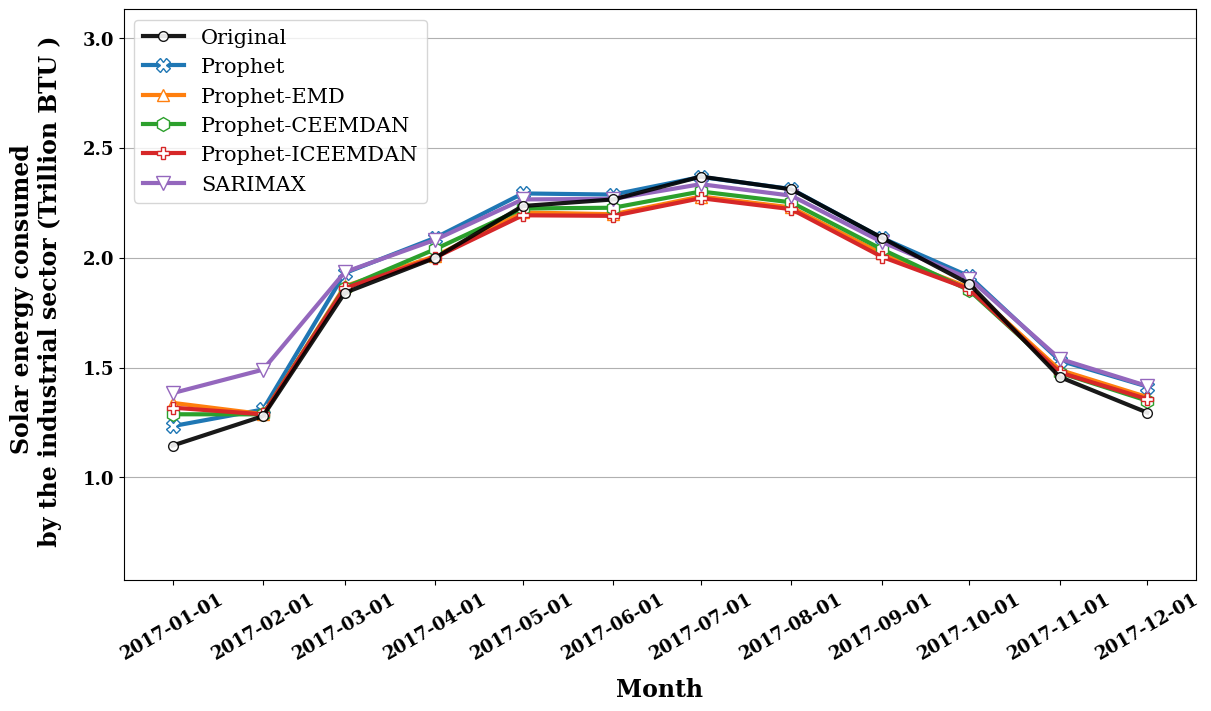

In [ ]:
plotting_test(df, df1, df2, df3,df4, df5, "Solar energy consumed \n by the industrial sector (Trillion BTU )", "Month", "solar_test_func.jpg",solar_test_size)

### bar plot

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] += ['Times Roman']
width = 0.1

def bar_plotter(values, title, name, tick):
  xticks = ['MAPE']
  multiplier = 0
  x = np.arange(len(xticks))

  fig, ax = plt.subplots(layout="constrained", figsize=(10,6))

  for i,j in values.items():
    offset = width * multiplier
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] += ['Times Roman']
    rects = ax.bar(x + offset, j, width, label = i)
    ax.bar_label(rects, padding=4, fontweight="bold", fontsize=13)
    multiplier+=1

  plt.legend(fontsize=13, loc="upper left")

  ax.set_xticks(x+tick, xticks, fontsize=14, fontweight="bold")
  plt.yticks(fontweight='bold', fontsize=14)

  ceil = round(max(list(values.values())) + 0.2*(max(list(values.values()))))

  plt.ylim(0, ceil)

  plt.grid(axis='y')
  ax.set_axisbelow(True)
  plt.margins(2*(1-len(values)/10), 0)
  plt.savefig(f"{name}.jpg", dpi=1200)

round


In [ ]:
def rounder(dictionary):
  for i,j in dictionary.items():
    dictionary[i] = round(j, 2)
  return(dictionary)

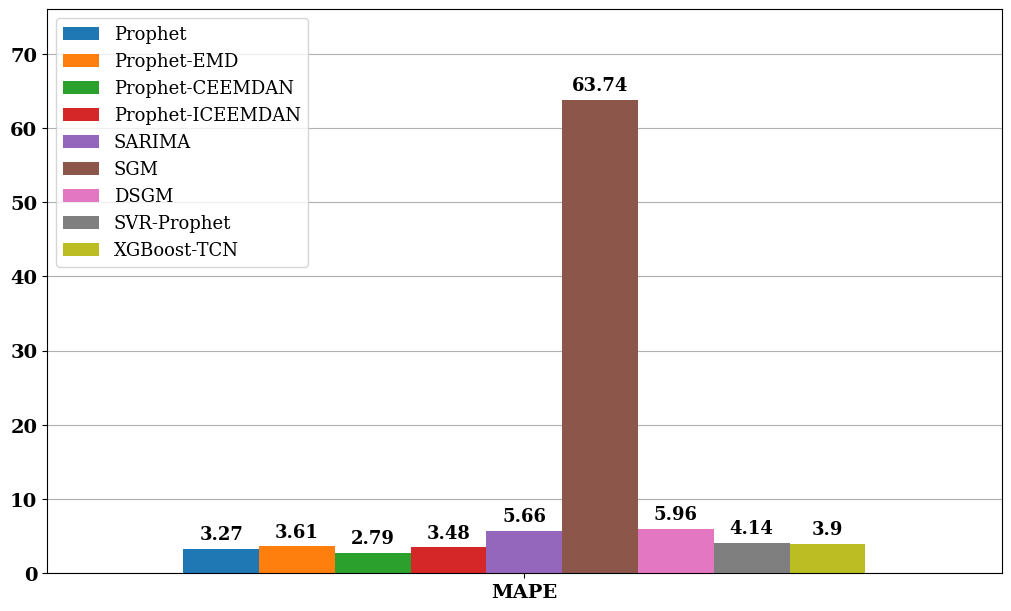

In [ ]:
solar_mape = {
    # method : (MAPE)
    "Prophet":(3.27),
    "Prophet-EMD": (3.61),
    "Prophet-CEEMDAN":(2.79),
    "Prophet-ICEEMDAN": (3.48),
    "SARIMA":(5.66),
    "SGM": (63.74) ,
    "DSGM" : (5.96),
    "SVR-Prophet" : (4.14),
    "XGBoost-TCN" : (3.897)
}

bar_plotter(rounder(solar_mape), "Solar energy consumption evaluation", "Solar_comparison_bar", 0.4)